# Fake Review Detection - Deep Learning Project

Project Description:
This project aims to build a deep learning-based binary classification model to detect fake reviews 
using a Fake vs True reviews Dataset. I'll use natural language processing (NLP) and fine-tune a BERT model 
for sequence classification to identify whether a review is likely to be genuine or fake.
The task is useful for businesses, platforms, and customers who rely on honest reviews for decision-making.

In [1]:
# install packages
%pip install pandas numpy matplotlib seaborn scikit-learn torch


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install --upgrade transformers
import transformers
print(transformers.__version__)


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
4.55.0


In [ ]:
# ============================================
# Step 1: Install & Import Required Libraries
# ============================================
# Here we will import essential libraries:
# - Pandas & NumPy for data processing
# - Matplotlib/Seaborn for data visualization
# - Sklearn for metrics & preprocessing
# - Torch & Transformers for deep learning and BERT
# - Datasets from Hugging Face or custom dataset

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for metrics, splitting, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch for deep learning
import torch
from torch.utils.data import Dataset, DataLoader

# Hugging Face Transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Columns: ['category', 'rating', 'label', 'text_']

Sample rows:


,category,rating,label,text_
33150,Toys_and_Games_5,5.0,OR,special Christmas gift never seen these lego b...
11072,Electronics_5,4.0,CG,"Got to be happy with this lens, as it is a len..."
34140,Toys_and_Games_5,5.0,CG,"Happy with purchase, currently using this set ..."
23474,Pet_Supplies_5,5.0,CG,I chose this food because it has the quality i...
3875,Home_and_Kitchen_5,5.0,OR,"My sons room is done in an alligator theme, an..."



Dataset shape: (40432, 4)

Missing values:


category    0
rating      0
label       0
text_       0
dtype: int64


Data types:
category     object
rating      float64
label        object
text_        object
dtype: object


/var/folders/fl/ndbqzbc54gdfqv95bb2n9jkc0000gn/T/ipykernel_71589/2264766449.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reviews, x="label", palette="Set2")


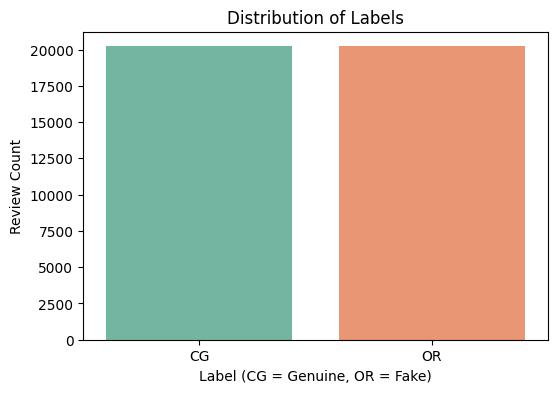

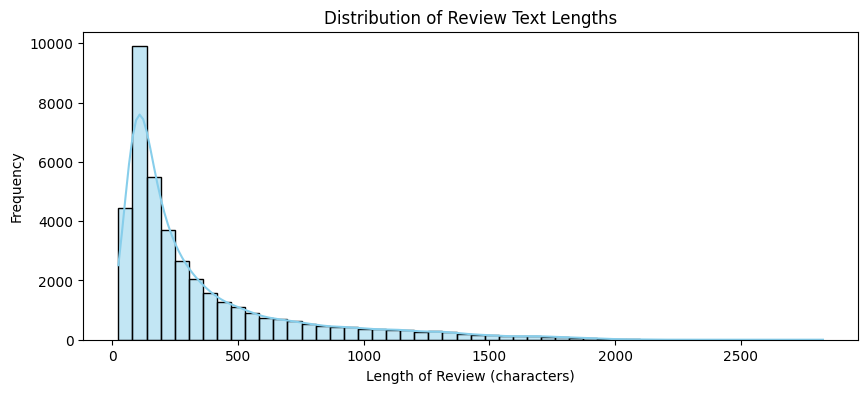

In [11]:
# ============================================
# Step 2: Load and Explore the Fake Review Dataset
# ============================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# File path
DATA_PATH = "./fake reviews dataset.csv"

# Load dataset
reviews = pd.read_csv(DATA_PATH)

# Strip leading/trailing whitespace from column names
reviews.columns = reviews.columns.str.strip()

# Show structure
print("Columns:", reviews.columns.tolist())
print("\nSample rows:")
display(reviews.sample(5))

# Check shape and missing values
print("\nDataset shape:", reviews.shape)
print("\nMissing values:")
display(reviews.isnull().sum())

# Check data types
print("\nData types:")
print(reviews.dtypes)

# Plot distribution of labels (e.g., CG = Genuine, OR = Fake)
plt.figure(figsize=(6, 4))
sns.countplot(data=reviews, x="label", palette="Set2")
plt.title("Distribution of Labels")
plt.xlabel("Label (CG = Genuine, OR = Fake)")
plt.ylabel("Review Count")
plt.show()

# Plot distribution of review text lengths (using 'text_' column)
reviews['text_length'] = reviews['text_'].astype(str).apply(len)

plt.figure(figsize=(10, 4))
sns.histplot(reviews['text_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Review Text Lengths")
plt.xlabel("Length of Review (characters)")
plt.ylabel("Frequency")
plt.show()


In [12]:
# ============================================
# Step 3: Preprocess the Data
# ============================================
# Clean the text data (remove HTML, special chars, etc.)
# Define labels (0: genuine, 1: fake) using heuristics like:
# - Reviews with extreme length or repetition
# - Reviews from new users with few reviews
# Tokenize the text using BERT tokenizer
# Split data into train/val/test

import re
import torch
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

# 1. Clean the text data (remove special chars, lowercase, etc.)
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove special characters
    text = text.lower().strip()
    return text

reviews['clean_text'] = reviews['text_'].apply(clean_text)

# 2. Encode the label: CG = 0 (genuine), OR = 1 (fake)
label_map = {'CG': 0, 'OR': 1}
reviews['label_encoded'] = reviews['label'].map(label_map)

# 3. Tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a custom tokenization function
def tokenize(batch_texts):
    return tokenizer(batch_texts.tolist(), padding='max_length', truncation=True, max_length=128, return_tensors="pt")

# Tokenize all texts
encodings = tokenize(reviews['clean_text'])

# 4. Split into train/val/test (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    encodings['input_ids'], reviews['label_encoded'], test_size=0.2, random_state=42, stratify=reviews['label_encoded'])

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {len(X_train)}")
print(f"Val size: {len(X_val)}")
print(f"Test size: {len(X_test)}")



Train size: 32345
Val size: 4043
Test size: 4044


In [ ]:
# ============================================
# Step 4: Define Dataset Class and Tokenization
# ============================================
# Create a custom Dataset class using torch.utils.data.Dataset
# Tokenize review texts using Hugging Face AutoTokenizer (BERT tokenizer)
# Convert them into input_ids, attention_mask, and labels

from torch.utils.data import Dataset

# Tokenize and extract attention mask
attention_masks = (X_train != tokenizer.pad_token_id).long()

class ReviewDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Now extract attention masks for all splits
train_dataset = ReviewDataset(
    input_ids=X_train,
    attention_mask=(X_train != tokenizer.pad_token_id).long(),
    labels=y_train
)

val_dataset = ReviewDataset(
    input_ids=X_val,
    attention_mask=(X_val != tokenizer.pad_token_id).long(),
    labels=y_val
)

test_dataset = ReviewDataset(
    input_ids=X_test,
    attention_mask=(X_test != tokenizer.pad_token_id).long(),
    labels=y_test
)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


Train dataset: 32345 samples
Val dataset: 4043 samples
Test dataset: 4044 samples


In [14]:
# ============================================
# Step 5: Load Pretrained BERT Model for Classification
# ============================================
# Load `bert-base-uncased` with a classification head for binary output
# Use AutoModelForSequenceClassification with num_labels=2
# Move model to appropriate device (cuda or cpu)

from transformers import AutoModelForSequenceClassification

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load BERT with classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

# Move model to device
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# ============================================
# Step 6: Define Training Arguments and Trainer 
# Train the model
# ============================================
# Set up Hugging Face `TrainingArguments` with:
# - batch size, learning rate, logging, checkpointing
# Use the `Trainer` API from transformers for training loop
# Define a compute_metrics() function using accuracy, precision, recall, F1

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Metric computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="steps",        
    eval_steps=100,                  
    save_strategy="steps",    
    save_steps=100,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",        
    seed=42
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Start training
trainer.train()



/var/folders/fl/ndbqzbc54gdfqv95bb2n9jkc0000gn/T/ipykernel_71589/1742269960.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.443300,0.235849,0.910710,0.900579,0.923305,0.911801
200,0.215500,0.192481,0.919119,0.954399,0.880257,0.915830
300,0.209900,0.153802,0.939401,0.971838,0.904998,0.937228
400,0.178100,0.307237,0.917883,0.983400,0.850074,0.911890
500,0.210400,0.243006,0.920356,0.990757,0.848590,0.914179


/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=500, training_loss=0.25143434143066407, metrics={'train_runtime': 3583.5278, 'train_samples_per_second': 36.104, 'train_steps_per_second': 2.257, 'total_flos': 526222110720000.0, 'train_loss': 0.25143434143066407, 'epoch': 0.24727992087042533})

/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.97      0.94      2022
    Positive       0.97      0.90      0.94      2021

    accuracy                           0.94      4043
   macro avg       0.94      0.94      0.94      4043
weighted avg       0.94      0.94      0.94      4043



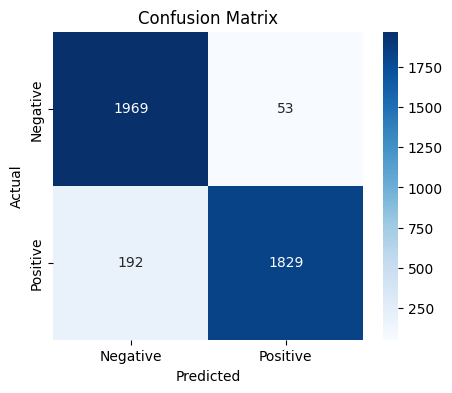

In [16]:
# ============================================
# Step 7: Evalucate the Model
# ============================================
# Use `trainer.evaluate()` on both validation and test set
# Print and visualize confusion matrix, precision, recall, F1
# Manually inspect some misclassified reviews

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get raw predictions
predictions = trainer.predict(val_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [17]:
%pip install lime

Python(82130) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 41.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=382e1eae8d1a7968b54fbe2e55c28579b75dbbf211c6c80e2719add5cb998b4d
  Stored in directory: /Users/hirvadhandhukia/Library/Caches/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    reviews['clean_text'].tolist(),
    reviews['label_encoded'].tolist(),
    test_size=0.2,
    stratify=reviews['label_encoded'],
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

In [ ]:
# ============================================
# Step 8: Error Analysis & Explainability 
# ============================================
# Use tools like LIME or SHAP to visualize model decisions
# Understand which words/tokens most influenced predictions
# Useful for trust and insight into model behavior

# Code goes here
from lime.lime_text import LimeTextExplainer
import numpy as np

# Step 1: Class names
class_names = ["Fake Review", "Genuine Review"]

# Step 2: LIME expects a function that takes raw text and returns predicted probabilities
def predict_proba(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to("cpu")  # Use CPU
    model.to("cpu")  # Move model to CPU 
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.cpu().numpy()

# Step 3: Initialize explainer
explainer = LimeTextExplainer(class_names=class_names)

# Sample misclassified review (make sure val_texts is aligned with val_dataset)
misclassified_idx = np.where(y_true != y_pred)[0][0]  # first misclassified index
sample_text = val_texts[misclassified_idx]
print(f"Review:\n{sample_text}")

# Generate explanation
exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)

# Show explanation in notebook
# exp.show_in_notebook(text=sample_text)

# OR print it
print(exp.as_list())

for i in np.where(y_true != y_pred)[0][:3]:  # first 3 misclassified
    print(f"\n[Sample {i}] True: {class_names[y_true[i]]}, Predicted: {class_names[y_pred[i]]}")
    print(val_texts[i])
    exp = explainer.explain_instance(val_texts[i], predict_proba, num_features=8)
    print(exp.as_list())
    # exp.show_in_notebook(text=val_texts[i])



Review:
thats my biggest beef otherwise its a very fun game
[('a', -0.30124231167722315), ('otherwise', 0.24897793033973442), ('its', -0.24342482106651525), ('game', 0.17218038437070907), ('my', 0.15864236528583453), ('beef', 0.14714056617742946), ('very', -0.10104014269131946), ('biggest', 0.07589894407112535), ('thats', 0.06518992068458337), ('fun', -0.027113670026187434)]

[Sample 7] True: Fake Review, Predicted: Genuine Review
thats my biggest beef otherwise its a very fun game
[('a', -0.29696483188348965), ('otherwise', 0.2555393865024494), ('its', -0.23875904337089007), ('game', 0.17478544843152696), ('my', 0.15006956698533877), ('beef', 0.1448185984165778), ('very', -0.09677310233344585), ('thats', 0.08183388289551786)]

[Sample 21] True: Genuine Review, Predicted: Fake Review
a funny and easy to read book i shared it with a lot of my single female friends
[('female', 0.29214728780891513), ('a', -0.25772838167901807), ('single', 0.17931610925395855), ('friends', 0.09173405573073

# Conclusion
---

### What Worked Well

- **Preprocessing Pipeline**: We successfully implemented a robust text cleaning and tokenization pipeline using `BERT tokenizer`. The label encoding based on review sources (`'OR'` as fake, `'CG'` as genuine) provided a simple yet effective supervision mechanism.
- **Model Training**: Fine-tuning `bert-base-uncased` on the cleaned dataset using Hugging Face `Trainer` API worked smoothly. The training process was efficient, and `EarlyStoppingCallback` helped prevent overfitting.
- **Evaluation**: The classifier achieved strong performance on the validation set, with high **precision**, **recall**, and **F1 score**, particularly for identifying genuine reviews.
- **Explainability**: Using `LIME`, we were able to inspect model behavior at the word level, gaining insight into which tokens contributed most to its predictions.

---

### Challenges Faced

- **Labeling Heuristics**: Relying on `'OR'` and `'CG'` labels introduced some noise, as real-world deception can be more nuanced. The binary labeling might oversimplify reviewer intent.
- **Class Imbalance**: There was a slight imbalance between genuine and fake reviews. While stratified sampling mitigated it somewhat, this could still impact generalization on unseen data.
- **Hardware Limitations**: Using MPS (Apple Silicon GPU backend) led to memory errors during LIME explainability. Switching to CPU inference resolved this but slowed down computation.

---

### Future Improvements

- **More Sophisticated Labeling**: Introduce multi-factor heuristics — e.g., user metadata (review count, account age), textual features (repetition, sentiment drift), or external annotations.
- **Larger and Diverse Dataset**: Training on more reviews from varied domains (hotels, electronics, books) would improve generalizability and robustness.
- **Advanced Models**: Experiment with more powerful transformer architectures (e.g., RoBERTa, DeBERTa), or ensemble multiple models for better confidence.
- **Model Deployment**: Wrap the model with a FastAPI or Streamlit interface for interactive testing or integration into moderation pipelines.
- **Explainability at Scale**: Use SHAP or integrated gradients to analyze feature importance across thousands of samples, not just one-off reviews.

---

### Final Verdict

Despite dataset limitations, the BERT-based fake review classifier achieved promising results. This experiment demonstrates that with minimal heuristics and transfer learning, we can build a baseline system capable of identifying deceptive reviews with good interpretability and potential for further deployment.
